In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from time import time

from multi_arm import epsilon_greedy

### Simulation Setup
__Bernoulli__ helper function simulates conversion.

```python
def bernoulli(p):
    return np.random.rand() < p
```

__two-sample z test__ is performed between the winner and second place arms. Algorithm is terminated if the two arms show statistical significance.

```python
def two_sample_z_test(est_p, wins, traffic, alpha=0.05):
    winner_idx = np.argmax(est_p)
    second_idx = sorted([(p, i) for i, p in enumerate(est_p)])[-2][1]
    p1, p2 = est_p[winner_idx], est_p[second_idx]
    x1, x2 = wins[winner_idx], wins[second_idx]
    n1, n2 = traffic[winner_idx], traffic[second_idx]

    p_pooled = (x1 + x2) / (n1 + n2)
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1 / n1 + 1 / n2))
    z = (p1 - p2) / se
    p_val = 2*(1 - norm.cdf(abs(z)))
    
    return p_val < alpha
```

__epsilon-greedy algorithm__ divert traffic to winning arm with probability $1-\epsilon$, randomly explore non-winning arm with probability $\epsilon$.

```python
def epsilon_greedy(ctrs, alpha=0.05, epsilon=0.3, burn_in=100, max_iter=100000, silent=False):
    idx = winner_idx = 0
    n_arm = len(ctrs)
    wins = np.array([0] * n_arm)
    traffic = np.array([1] * n_arm)
    history = [[] for _ in range(n_arm)]

    for i in range(max_iter):    
        if np.random.rand() < epsilon:
            # randomly choose a arm
            while idx == winner_idx:
                idx = np.random.randint(0, len(ctrs))
        else:
            # greedily use the best arm
            idx = winner_idx
        ctr = ctrs[idx]

        # new user arrives
        conversion = bernoulli(ctr)

        wins[idx] += int(conversion)
        traffic[idx] += 1

        if sum(wins) != 0:
            est_p = wins / traffic
            winner_idx = np.argmax(est_p)

            for j, p in enumerate(est_p):
                history[j].append(p)

        if i >= burn_in:
            if two_sample_z_test(est_p, wins, traffic, alpha):
                if not silent: print("Winning arm %i beats second arm at iteration %i"%(winner_idx, i + 1))
                break
    return winner_idx, est_p, traffic, history
```

### A Single Trial

In [2]:
ctrs = np.random.normal(0.2, 0.05, 10)

true_winner_idx = np.argmax(ctrs)
print("true_winner_idx:", true_winner_idx)

epsilon = 0.2
alpha = 0.05
winner_idx, est_p, wins, traffic, history = epsilon_greedy(ctrs, alpha, epsilon, burn_in=5000)

true_winner_idx: 9
Winning arm 9 beats second arm at iteration 26728


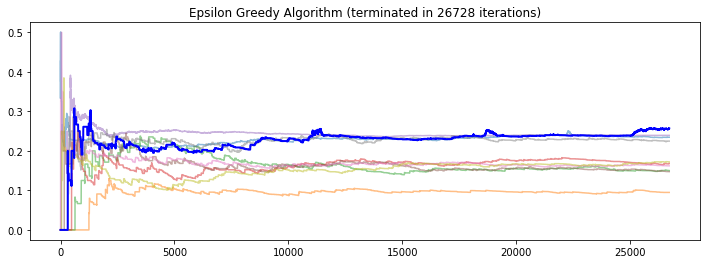

In [3]:
# iteration is same as sum(traffic) - len(ctrs)

# History Plot
plt.figure(figsize=(12, 4))
for i, hist in enumerate(history):
    if i == true_winner_idx :
        plt.plot(hist, lw=2, color='b')
    elif i == winner_idx:
        plt.plot(hist, lw=2, color='r')
    else:
        plt.plot(hist, alpha=0.5)

# plt.legend(["true ctr = %.2f, est ctr = %.2f"%(true, est) for true, est in zip(ctrs, est_p)],
#           loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("Epsilon Greedy Algorithm (terminated in %i iterations)"%(sum(traffic) - len(ctrs)))

plt.show()

In [4]:
conversion = 100 * sum(wins) / sum(traffic)
baseline = 100 * sum(np.array(ctrs) * (sum(traffic) / len(ctrs))) / sum(traffic)
print("good traffic: %i / %i = %.2f%%, baseline %.2f%%"%(sum(wins), 
                                                         sum(traffic), 
                                                         conversion,
                                                         baseline))

good traffic: 6099 / 26738 = 22.81%, baseline 18.56%


##### Moving Average Smoothing

In [5]:
cols = ["arm_%i_ctr=%.2f"%(i + 1, ctr) for i, ctr in enumerate(ctrs)]
data = {col : hist for col, hist in zip(cols, history)}
df_history = pd.DataFrame(data)

df_history_ma = df_history.rolling(1000).mean()

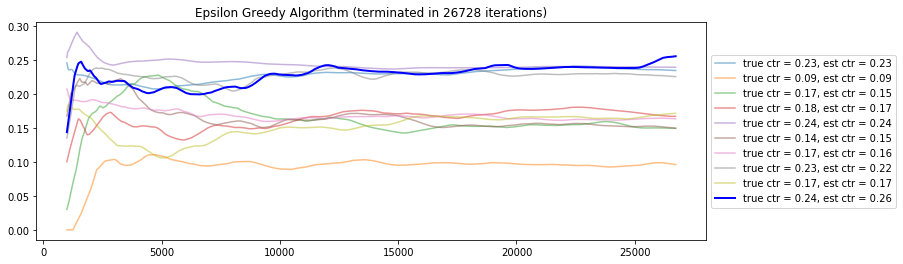

In [6]:
plt.figure(figsize=(12, 4))
for i, col in enumerate(cols):
    if i == true_winner_idx :
        plt.plot(df_history_ma[col], lw=2, color='b')
    elif i == winner_idx:
        plt.plot(df_history_ma[col], lw=2, color='r')
    else:
        plt.plot(df_history_ma[col], alpha=0.5)
    
plt.legend(["true ctr = %.2f, est ctr = %.2f"%(true, est) for true, est in zip(ctrs, est_p)],
          loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Epsilon Greedy Algorithm (terminated in %i iterations)"%(sum(traffic) - len(ctrs)))

plt.savefig('outputs/epsilon_%.2f_greedy.png'%epsilon)
plt.show()

### True Positive Rate

In [7]:
start = time()

ctrs = [0.1, 0.2, 0.15]
alpha = 0.05
epsilon = 0.5
true_winner_idx = np.argmax(ctrs)
n_trials = 100
success = 0
iters = []

for i in range(n_trials):
    winner_idx, _, _, traffic, _ = epsilon_greedy(ctrs=ctrs, alpha=alpha, epsilon=epsilon, silent=True)
    iters.append(sum(traffic) - len(ctrs))
    if winner_idx == true_winner_idx:
        success += 1
    if i % 10 == 0:
        print("Progress %.2f%%..."%(100 * i / n_trials), end="\r")
print("probability of finding winner: %.2f%%"%(100 * success / n_trials))

end = time()
print("time elapsed: %.2fs"%(end - start))

probability of finding winner: 96.00%
time elapsed: 10.96s


average iteration 940.41, median 671.50, std 884.03


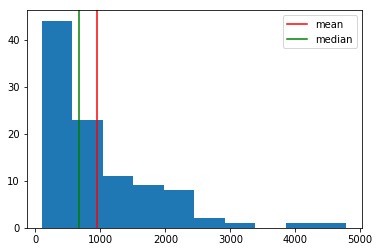

In [9]:
print("average iteration %.2f, median %.2f, std %.2f"%(np.mean(iters), np.median(iters), np.std(iters)))

plt.axvline(np.mean(iters), color='r')
plt.axvline(np.median(iters), color='g')
plt.hist(iters)

plt.legend(["mean", "median"])
plt.show()